In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy
import pickle

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse
from jaxley.utils.colors import network_cols

In [5]:
nseg_per_branch = 2

### Visualize trace

In [6]:
names = []
for x in os.walk("../../../nex/ca1net/morphologies"):
    if len(x[0]) < 40 and len(x[0]) > 32:
        names.append(x[0])
        fnames = [f"{n}/{n[-4:]}.CNG.swc" for n in names]

In [14]:
cells = []
for fname in fnames:
    cell = jx.read_swc(fname, nseg_per_branch, max_branch_len=500.0)
    if cell.total_nbranches < 280:
        cells.append(cell)

size_factor = 40
sf = size_factor  # abbreviate
all_cells = []
for _ in range(size_factor):
    all_cells = all_cells + cells

all_cells = all_cells + [cells[1]]
cells = all_cells
print("Number of cells: ", len(cells))

Number of cells:  101


In [15]:
# cols = []
# for a in [10, 10, 10, 10, 10, 1]:
#     cols += network_cols([a*sf])

_ = np.random.seed(0)
cols = np.asarray(network_cols([20*sf, 10*sf, 10*sf, 10*sf+1])) # , 10*sf, 1]))
permutation = np.random.permutation(np.arange(len(cols)))
cols = cols[permutation]
cols[-1] = [0.0, 0.0, 0.0, 1.0]

In [16]:
from jaxley.connect import sparse_connect, fully_connect

In [17]:
network = jx.Network(cells)
print("Initialized network")

_ = np.random.seed(2)  # location of post synapse is random.

prob = 0.0005
pre = network.cell(np.arange(0*sf, 10*sf).tolist())
post = network.cell(np.arange(10*sf, 20*sf).tolist())
sparse_connect(pre, post, IonotropicSynapse(), prob)
print("First layer done")

pre = network.cell(np.arange(10*sf, 20*sf).tolist())
post = network.cell(np.arange(20*sf, 30*sf).tolist())
sparse_connect(pre, post, IonotropicSynapse(), prob)
print("Second layer done")

pre = network.cell(np.arange(20*sf, 30*sf).tolist())
post = network.cell(np.arange(30*sf, 40*sf).tolist())
sparse_connect(pre, post, IonotropicSynapse(), prob)
print("Third layer done")

pre = network.cell(np.arange(30*sf, 40*sf).tolist())
post = network.cell(np.arange(40*sf, 50*sf).tolist())
sparse_connect(pre, post, IonotropicSynapse(), prob)
print("Forth layer done")

pre = network.cell(np.arange(40*sf, 50*sf).tolist())
post = network.cell(50*sf)
sparse_connect(pre, post, IonotropicSynapse(), 0.1)

x_factor = 2.0
x_spacing = 5.7 * x_factor
y_spacing = 1300
y_jitter = 150.0
counter = 0
x_rands = np.random.randint(-500, 500, (10*sf,))
y_rands = np.random.randn(10*sf) * y_jitter

move_xs = []
move_ys = []
for i in range(10 * sf):
    network.cell(i).move(x_rands[counter] * x_spacing, 5*y_spacing + y_rands[counter], 0, update_nodes=False)
    counter += 1

counter = 0
x_spacing += 0.3 * x_factor
x_rands = np.random.randint(-500, 500, (10*sf,))
y_rands = np.random.randn(10*sf) * y_jitter
for i in range(10 * sf, 20 * sf):
    network.cell(i).move(x_rands[counter] * x_spacing, 4*y_spacing + y_rands[counter], 0, update_nodes=False)
    counter += 1

counter = 0
x_spacing -= 0.1 * x_factor
x_rands = np.random.randint(-500, 500, (10*sf,))
y_rands = np.random.randn(10*sf) * y_jitter
for i in range(20 * sf, 30 * sf):
    network.cell(i).move(x_rands[counter] * x_spacing, 3*y_spacing + y_rands[counter], 0, update_nodes=False)
    counter += 1

counter = 0
x_spacing += 0.1 * x_factor
x_rands = np.random.randint(-500, 500, (10*sf,))
y_rands = np.random.randn(10*sf) * y_jitter
for i in range(30 * sf, 40 * sf):
    network.cell(i).move(x_rands[counter] * x_spacing, 2*y_spacing + y_rands[counter], 0, update_nodes=False)
    counter += 1

counter = 0
x_spacing -= 0.2 * x_factor
x_rands = np.random.randint(-500, 500, (10*sf,))
y_rands = np.random.randn(10*sf) * y_jitter
for i in range(40 * sf, 50 * sf):
    network.cell(i).move(x_rands[counter] * x_spacing, 1*y_spacing + y_rands[counter], 0, update_nodes=False)
    counter += 1

network.cell(50 * sf).move(0, 0*y_spacing, 0, update_nodes=False)

Initialized network
First layer done
Second layer done
Third layer done
Forth layer done


In [18]:
num_synapses = len(network.edges)
print(f"Number of synapses: {num_synapses}")

Number of synapses: 8


### Visualize

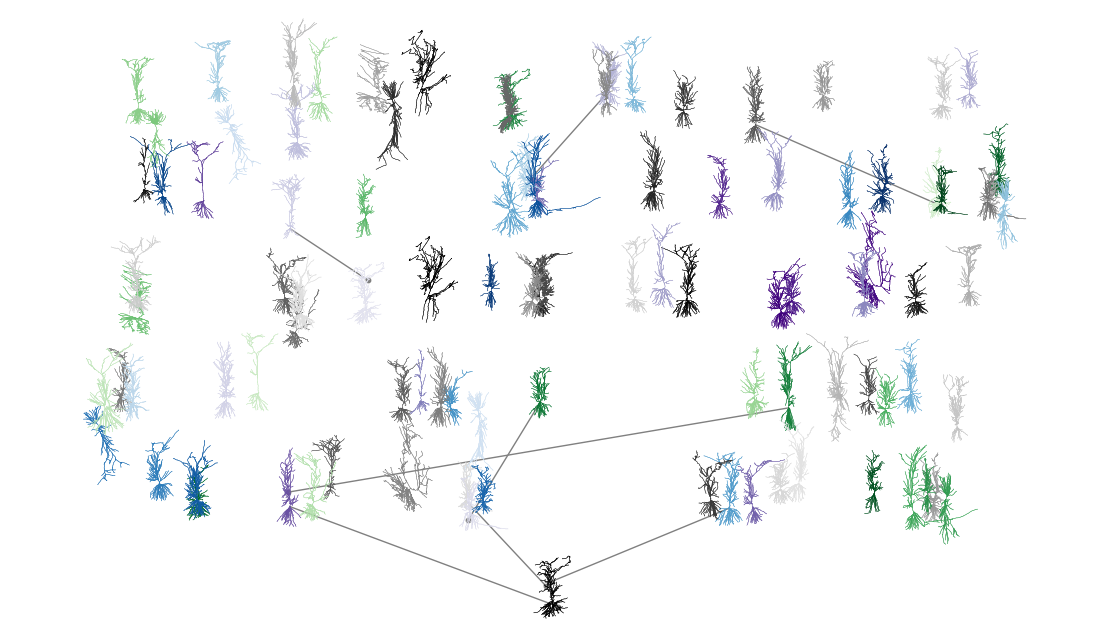

In [19]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(7*x_factor, 8))

    # Plot only synapses, because morph has alpha=0.0
    ax = network.vis(
        ax=ax,
        col="k",
        synapse_col="gray",
        morph_plot_kwargs={"alpha": 0.0},
        synapse_plot_kwargs={"zorder": -1000},
        synapse_scatter_kwargs={"s": 10.0, "zorder": -1000},
    )

    # Plot only cells, because we are plotting CellView
    for i in np.arange(0, len(cells)):
        ax = network.cell(i).vis(
            ax=ax,
            col=cols[i],
            morph_plot_kwargs={"linewidth": 0.3},
        )
    _ = ax.set_ylim([-300, 7700])
    _ = ax.set_xlim([-3500*x_factor, 3500*x_factor])
    _ = ax.spines["left"].set_visible(False)
    _ = ax.spines["bottom"].set_visible(False)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    plt.savefig("../svg/large_net_very_wide.png", dpi=200, transparent=True)
    plt.show()